# Analyzing NYC High School Data

## Background

The [SAT](https://en.wikipedia.org/wiki/SAT), or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on [student SAT scores](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) high school, along with additional demographic data sets. Over the last three missions, we combined the following data sets into a single, clean pandas dataframe:

* [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
* [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

In this project, we will explore the relationships and correlation between SAT scores and other variables.

## Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

There are several fields in combined that originally came from a survey of parents, teachers, and students. Let's make a bar plot of the correlations between these fields and sat_score.

But first, we include some helper functions to conveniently plot our graphs.

In [11]:
# Set color palette
# http://tools.medialab.sciences-po.fr/iwanthue/

def hex_to_rgb(hex):
    hex = hex.lstrip('#')
    hlen = len(hex)
    return [int(hex[i:i+hlen//3], 16) for i in range(0, hlen, hlen//3)]

def normalize_primary(hex: str)-> tuple:
    return tuple(map(lambda x: x/255, hex_to_rgb(hex)))
    
def normalize_subdued(hex: str,a: float)-> tuple:
    c = hex_to_rgb(hex)
    return (c[0]/255,c[1]/255,c[2]/255,a)
                 
def gen_primary(colors: dict)-> dict:
    return {name+'_p':normalize_primary(rgb) for name, rgb in colors.items()}

def gen_subdued(colors: dict, alpha: float = 0.25)-> dict:
    return {name+'_s':normalize_subdued(rgb, alpha) for name, rgb in colors.items()}

scheme_A = { 
    'red': "#ca0e69",
    'green': "#009a6b",
    'purple': "#8960b3",
    'orange': "#ff8c53",
    'lime': "#909e3f"
}
                 
def normalize_colors(colors: dict, alpha: float = 0.25)-> dict:
    np = gen_primary(colors)
    ns = gen_subdued(colors, alpha)
    np.update(ns)
    return np

cpA = normalize_colors(scheme_A)

def get_color_list(
    n: int,
    hl_pos: [int],
    hl_c: str = 'slategrey',
    sd_c: str = 'lightgrey'
    )-> [str]:
    highlight_color = hl_c
    subdued_color   = sd_c
    cl = []
    for i in range(0,n):
        if i in hl_pos:
            cl.append(highlight_color)
        else:
            cl.append(subdued_color)
    return cl

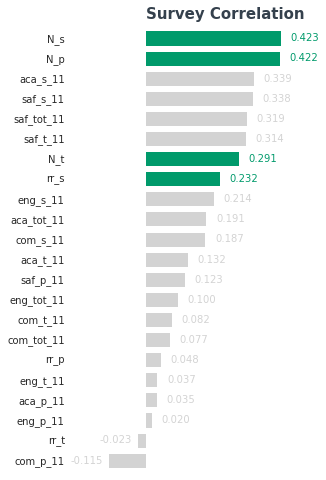

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white')
%matplotlib inline

fig, ax = plt.subplots(figsize=(4,8))
idx=len(list(combined.index))
bar_color = get_color_list(idx,[14,15,20,21],cpA['green_p'])

sat_corr = combined.corr()["sat_score"][survey_fields].sort_values()
sat_corr.plot.barh(ax=ax, width=0.7, color=bar_color, linewidth=0)

label_vertspace = 0.1

for i, label in enumerate(list(sat_corr)):
    score = float(label)
    label = '{:.3f}'.format(score)
    label_horspace = -0.12 if score < 0.0 else 0.03
    plt.text(score + label_horspace,
             i - label_vertspace,
             label,
             color=bar_color[i])
  
ax.text(0, 22, 'Survey Correlation', fontsize=15, fontweight='black', color = '#333F4B')
ax.spines['left'].set_position(('outward', 10))
sns.despine(ax=ax,left=True, bottom=True, top=True, right=True)
ax.tick_params(top="off", right="off", left="off", bottom="off", labelbottom=False)

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

## Investigating Safety Scores

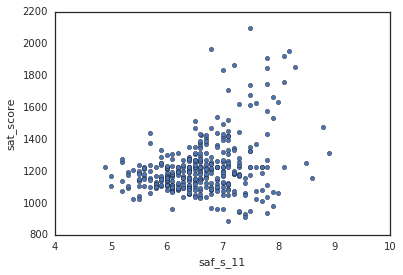

In [13]:
combined.plot.scatter("saf_s_11", "sat_score")

There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

## Plotting Safety

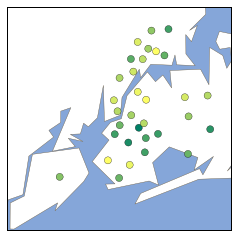

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.


## Racial differences in SAT scores

There are a few columns that indicate the percentage of each race at a given school:

* white_per
* asian_per
* black_per
* hispanic_per

By plotting out the correlations between these columns and `sat_score`, we can determine whether there are any racial differences in SAT performance.

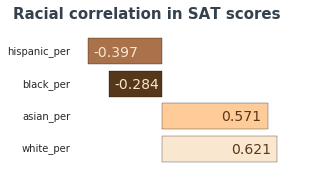

In [15]:
fig, ax = plt.subplots(figsize=(4,2.5))
bar_color = ['#fae7d0','#ffcc99','#573719','#aa724b']
label_color = ['#573719','#573719','#fae7d0','#fae7d0']
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.barh(ax=ax,width=0.8,color=bar_color)
ax.spines['left'].set_position(('outward', 10))
sns.despine(ax=ax,left=True, bottom=True, top=True, right=True)
ax.tick_params(axis='both',which='both',top="off", right="off", left="off", bottom="off", labelbottom=False)
ax.spines['left'].set_position(('outward', 10))
ax.text(-0.8, 4, 'Racial correlation in SAT scores', fontsize=15, fontweight='black', color = '#333F4B')

label_vertspace = 0.15
for i, label in enumerate(list(combined.corr()["sat_score"][race_fields])):
    score = float(label)
    label = '{:.3f}'.format(score)
    label_horspace = 0.03 if score < 0.0 else -0.25
    plt.text(score + label_horspace,
             i - label_vertspace,
             label,
             color=label_color[i],
             fontsize=14)

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

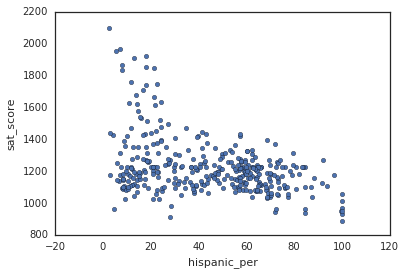

In [16]:
combined.plot.scatter("hispanic_per", "sat_score")

In [17]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [18]:
print(combined[(combined["hispanic_per"] < 10) & 
               (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

## Gender Differences in SAT Scores

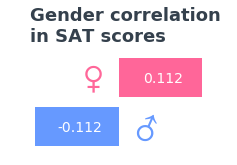

In [19]:
fig, ax = plt.subplots(figsize=(4,2))
bar_color = ['#6699ff','#ff6699']
label_color = ['#ffffff','#ffffff']
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.barh(ax=ax,width=0.8,linewidth=0,color=bar_color)
ax.spines['left'].set_position(('outward', 10))
sns.despine(ax=ax,left=True, bottom=True, top=True, right=True)
ax.tick_params(axis='both',which='both',top="off", right="off", left="off", bottom="off", labelleft=False,labelbottom=False)
ax.spines['left'].set_position(('outward', 10))
ax.text(-0.12, 1.75, 'Gender correlation\nin SAT scores', fontsize=18, fontweight='black', color = '#333F4B')

fem='$\u2640$'
mal='$\u2642$'
ax.text(-0.05, 0.8, fem, fontsize=35, fontweight='black', color=bar_color[1])
ax.text(0.02, -0.2, mal, fontsize=35, fontweight='black', color=bar_color[0])
label_vertspace = 0.1
for i, label in enumerate(list(combined.corr()["sat_score"][gender_fields])):
    score = float(label)
    label = '{:.3f}'.format(score)
    label_horspace = 0.03 if score < 0.0 else -0.08
    plt.text(score + label_horspace,
             i - label_vertspace,
             label,
             color=label_color[i],
             fontsize=14)

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

Next, let's investigate schools with high SAT scores and a high `female_per`.

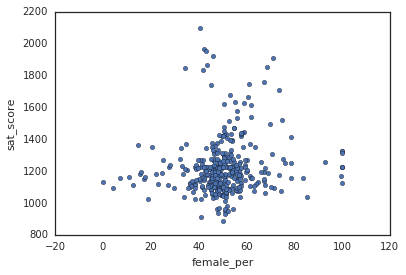

In [20]:
combined.plot.scatter("female_per", "sat_score")

Based on the scatterplot above, we don't see any noticeable correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores. Let's find out any schools with a female_per greater than 60% and an average SAT score greater than 1700.

In [21]:
print(combined[(combined['female_per']>60) & (combined['sat_score']>1700)]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards.

## AP Exam Scores vs SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.
It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. 

Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

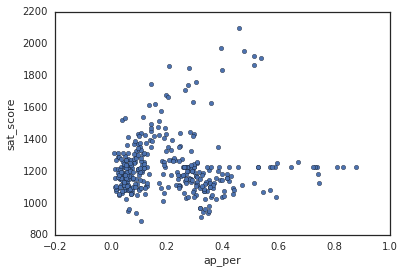

In [22]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

# Conclusion

In this project, we have perform some analysis regarding SAT score and its correlation with respect to other variables such as gender and race. It is possible to extend the analysis further, with some potential next steps:

* Determing wheter there's a correlation between `class size` and `SAT scores`
* Figuring out which neighborhoods have the best schools
* If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
* Investigating the differences between parent, teacher, and student responses to surveys.
* Assigning scores to schools based on `sat_score` and other attributes.